# Math Question Answer Verification Competition

## Starter Code

Borrowed from [official Unsloth implementation](https://colab.research.google.com/drive/1Ys44kVvmeZtnICzWz0xgpRnrIOjZAuxp?usp=sharing#scrollTo=MKX_XKs_BNZR)

In [1]:
# %%capture
# This cell will take time
!pip install unsloth
# Also get the latest nightly Unsloth!
!pip uninstall unsloth -y && pip install --upgrade --no-cache-dir "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"

Found existing installation: unsloth 2024.11.7
Uninstalling unsloth-2024.11.7:
  Successfully uninstalled unsloth-2024.11.7
  Cloning https://github.com/unslothai/unsloth.git to /tmp/pip-install-kt_8ci0b/unsloth_16da4005695846d3a6c19277722c0640
  Running command git clone --filter=blob:none --quiet https://github.com/unslothai/unsloth.git /tmp/pip-install-kt_8ci0b/unsloth_16da4005695846d3a6c19277722c0640
  Resolved https://github.com/unslothai/unsloth.git to commit f26d4e739ed507de7a9088da53d10fd02f58d160
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for unsloth: filename=unsloth-2024.11.7-py3-none-any.whl size=163138 sha256=f4a7304adfa265a67c1dc1937ed1fd9b4ef254cb1d59137ced2ddf226230762e
  Stored in directory: /tmp/pip-ephem-wheel-cache-0hj_qelw/wheels/ed/d4/e9/76fb290ee3df0a5fc21ce5c2c788e29e9607a2353d8342fd0d
Successfully built unsloth


In [2]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 2048 # Choose any
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


In [3]:
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Meta-Llama-3.1-8B",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)

==((====))==  Unsloth 2024.11.7: Fast Llama patching. Transformers = 4.46.2.
   \\   /|    GPU: NVIDIA A100-SXM4-40GB. Max memory: 39.564 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.5.1+cu121. CUDA = 8.0. CUDA Toolkit = 12.1.
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


## Load model and wrap with LoRA adapters

In [4]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

Unsloth 2024.11.7 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


## Competition dataset

In [5]:
# download and load competition dataset

from datasets import load_dataset
dataset = load_dataset("ad6398/nyu-dl-teach-maths-comp")
# print and see dataset
dataset

DatasetDict({
    train: Dataset({
        features: ['question', 'is_correct', 'answer', 'solution'],
        num_rows: 1000000
    })
    test: Dataset({
        features: ['question', 'is_correct', 'answer', 'solution'],
        num_rows: 10000
    })
})

In [6]:
# Define the prompt with corrected "Explanation" spelling
prompt = """You are a great mathematician and you are tasked with finding if an answer to a given maths question is correct or not. Your response should be 'True' if correct, otherwise 'False'. Below is the Question and Answer.
Use the given explanation to support your answer.
### Question:
{}

### Answer:
{}

### Explanation:
{}

### Output:
{}"""

# Ensure EOS token is used to signal end of response
EOS_TOKEN = tokenizer.eos_token

# Function to format prompts
def formatting_prompts_func(examples):
    questions = examples["question"]
    answers = examples["answer"]
    explanations = examples["solution"]
    outputs = examples["is_correct"]

    texts = []
    for question, answer, explanation, output in zip(questions, answers, explanations, outputs):
        # Include the EOS token at the end to prevent indefinite generation
        text = prompt.format(question, answer, explanation, output) + EOS_TOKEN
        texts.append(text)
    return {"text": texts}


In [7]:
# Process the training dataset and generate prompt for each datapoint

train_dataset = dataset['train'].map(formatting_prompts_func, batched = True,)

#Split the dataset


In [8]:
split_dataset = train_dataset.train_test_split(test_size=0.1, seed=3407)
train_dataset = split_dataset["train"]
valid_dataset = split_dataset["test"]

In [9]:
valid_dataset_small = valid_dataset.select(range(100))

In [10]:
#print a smaple training example
valid_dataset_small['answer'][1]

'616'

## SFT

In [11]:
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported

training_args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        # num_train_epochs = 1, # Set this for 1 full training run.
        max_steps = 2000,
        learning_rate = 2e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 20,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none", # Use this for WandB etc
        eval_strategy="steps",  # Evaluate during training
        eval_steps=20,
    )



In [12]:
trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset_small,  # Include validation dataset
    dataset_text_field="text",
    max_seq_length=max_seq_length,
    dataset_num_proc=4,
    packing=False,  # Can make training 5x faster for short sequences.
    args=training_args,
)

Map (num_proc=4):   0%|          | 0/100 [00:00<?, ? examples/s]

max_steps is given, it will override any value given in num_train_epochs


In [13]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 900,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 4
\        /    Total batch size = 8 | Total steps = 2,000
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss,Validation Loss
20,1.031100,0.749505
40,0.721700,0.703901
60,0.681800,0.693638
80,0.733000,0.689887
100,0.697400,0.685133
120,0.689800,0.684571
140,0.687500,0.678649
160,0.693900,0.679777
180,0.679500,0.676576
200,0.671000,0.674949


[0.7495052814483643, 0.7039005756378174, 0.6936375498771667, 0.6898871660232544, 0.685132622718811, 0.6845705509185791, 0.6786485910415649, 0.6797768473625183, 0.6765757203102112, 0.6749485731124878, 0.6720749735832214, 0.6713602542877197, 0.6671417951583862, 0.6644238829612732, 0.6601595878601074, 0.6584780812263489, 0.65727698802948, 0.6580820679664612, 0.6547132730484009, 0.6541843414306641, 0.6515023708343506, 0.6559255719184875, 0.6532983183860779, 0.6541213393211365, 0.6518983244895935, 0.651954174041748, 0.649178147315979, 0.6462299227714539, 0.6436706781387329, 0.6435701251029968, 0.6430410146713257, 0.6419064402580261, 0.641804039478302, 0.6410373449325562, 0.6404258012771606, 0.6415591239929199, 0.6414397358894348, 0.6395593881607056, 0.63881516456604, 0.6380417943000793, 0.6382879018783569, 0.6366224884986877, 0.6373392939567566, 0.6356546878814697, 0.633648157119751, 0.6363649964332581, 0.6344893574714661, 0.6345146298408508, 0.6344024538993835, 0.6318528056144714, 0.628709

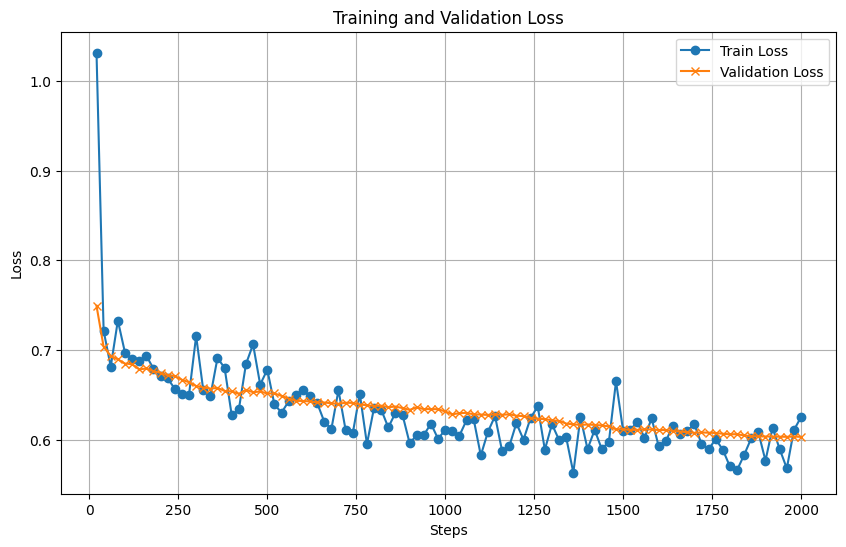

In [14]:
import matplotlib.pyplot as plt
def plot_training_loss(trainer):
    history = trainer.state.log_history
    steps = [h["step"] for h in history if "loss" in h]
    train_loss = [h["loss"] for h in history if "loss" in h]
    eval_loss = [h["eval_loss"] for h in history if "eval_loss" in h]

    print(eval_loss)
    plt.figure(figsize=(10, 6))
    plt.plot(steps, train_loss, label="Train Loss", marker="o")
    if eval_loss:
        plt.plot(steps, eval_loss, label="Validation Loss", marker="x")
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training and Validation Loss")
    plt.grid(True)
    plt.show()

plot_training_loss(trainer)

In [22]:

from tqdm import tqdm
test_dataset = valid_dataset.select(range(500))
FastLanguageModel.for_inference(model) # Enable native 2x faster inference
correct_predictions = 0  # Variable to track correct predictions
total_samples = len(test_dataset)

# Run inference for each data point in the selected test dataset
for idx, example in tqdm(enumerate(test_dataset), total=total_samples):
    sample_ques = example['question']  # Question from dataset
    sample_ans = example['answer']    # Answer from dataset
    samle_sol = example['solution']   # Solution from dataset
    sample_isc = example['is_correct']
    # Format the input prompt
    input_prompt = prompt.format(
        sample_ques,  # question
        sample_ans,   # answer
        samle_sol,
        "",           # output - leave this blank for generation
    )

    # Tokenize the input prompt
    inputs = tokenizer([input_prompt], return_tensors="pt").to("cuda")

    outputs = model.generate(**inputs, max_new_tokens=64, use_cache=True)

    # Decode the generated text
    response = tokenizer.batch_decode([outputs[0][inputs['input_ids'].shape[1]:]], skip_special_tokens=True)

    # Extract the model's output (e.g., "True" or "False")
    generated_text = response[0].strip().lower()  # Ensure the response is in lowercase (True/False)
    # Check if the response is correct (assuming correct answer is 'true' or 'false')
    is_correct = generated_text == 'true'

    # Track the number of correct predictions
    if is_correct == sample_isc:
        correct_predictions += 1

# Calculate accuracy
accuracy = correct_predictions / total_samples
print(f"Accuracy on the test dataset: {accuracy * 100:.2f}%")


100%|██████████| 500/500 [01:39<00:00,  5.03it/s]

Accuracy on the test dataset: 84.80%


## saving model

In [20]:
from google.colab import drive
drive.mount('/content/drive')

# Define the path where you want to save the model and tokenizer in your Google Drive
model_path = '/content/drive/MyDrive/lora_model'  # Replace with your desired path

# Save the model and tokenizer to the specified path
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

print(f"Model and tokenizer saved to Google Drive at {model_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model and tokenizer saved to Google Drive at /content/drive/MyDrive/lora_model_new


## Load Model


In [21]:
from google.colab import drive
drive.mount('/content/drive')
from unsloth import FastLanguageModel

# Define the path to your model and tokenizer in Google Drive
model_path = '/content/drive/MyDrive/lora_model'  # Change this to the correct path

# Define any necessary parameters
max_seq_length = 2048  # Example
dtype = None  # Automatically detected, or specify (e.g., torch.float16)
load_in_4bit = True  # Set to True if you used 4-bit quantization during saving

# Load the model and tokenizer
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name=model_path,  # Path to the saved model on Google Drive
    max_seq_length=max_seq_length,
    dtype=dtype,
    load_in_4bit=load_in_4bit,
)

# Enable native faster inference
FastLanguageModel.for_inference(model)

print("Model and tokenizer loaded successfully from Google Drive.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
==((====))==  Unsloth 2024.11.7: Fast Llama patching. Transformers = 4.46.2.
   \\   /|    GPU: NVIDIA A100-SXM4-40GB. Max memory: 39.564 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.5.1+cu121. CUDA = 8.0. CUDA Toolkit = 12.1.
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Model and tokenizer loaded successfully from Google Drive.


#Inference

In [ ]:
import pandas as pd
from tqdm import tqdm
from datasets import load_dataset
dataset = load_dataset("ad6398/nyu-dl-teach-maths-comp")
test_dataset = dataset['test']  # Replace with your actual test dataset

# Initialize the list to store results
results = []

# Run inference for each data point in the test dataset
for idx, example in tqdm(enumerate(test_dataset), total=len(test_dataset)):
    sample_ques = example['question']  # Question from dataset
    sample_ans = example['answer']    # Answer from dataset
    samle_sol = example['solution']   # Solution from dataset
    # Format the input prompt
    input_prompt = prompt.format(
        sample_ques,  # question
        sample_ans,   # answer
        samle_sol,
        "",           # output - leave this blank for generation
    )

    # Tokenize the input prompt
    inputs = tokenizer([input_prompt], return_tensors="pt").to("cuda")

    # Run the model to generate the output
    outputs = model.generate(**inputs, max_new_tokens=64, use_cache=True)

    # Decode the generated text
    response = tokenizer.batch_decode([outputs[0][inputs['input_ids'].shape[1]:]], skip_special_tokens=True)

    # Extract the model's output (e.g., "True" or "False")
    generated_text = response[0].strip().lower()  # Ensure the response is in lowercase (True/False)

    # Check if the response is correct (assuming correct answer is 'true' or 'false')
    is_correct = generated_text == 'true'

    # Append the result with ID and correctness
    results.append([idx, is_correct])

# Convert the results to a DataFrame
results_df = pd.DataFrame(results, columns=['ID', 'is_correct'])

# Save the results to a CSV file
results_df.to_csv("test_predictions.csv", index=False)

print("CSV file with predictions saved as 'test_predictions.csv'.")

drive_file_path = "/content/drive/My Drive/test_predictions.csv"
results_df.to_csv(drive_file_path, index=False)

print("CSV file with predictions saved as 'test_predictions.csv' both locally and in Google Drive.")

100%|██████████| 10000/10000 [33:02<00:00,  5.05it/s]


CSV file with predictions saved as 'test_predictions.csv'.
CSV file with predictions saved as 'test_predictions.csv' both locally and in Google Drive.
